In [15]:
using Turing
using LimberJack
using LinearAlgebra
using CSV
using NPZ
using Plots
using FITSIO
using ForwardDiff
using BenchmarkTools
using DelimitedFiles

In [16]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [17]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [18]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [19]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");
cls_carlos2 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp.npz");
cls_carlos3 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH.npz");
cls_carlos4 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH_noconv.npz");

In [20]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "m0" => pars[17],
                 "m1" => pars[18],
                 "m2" => pars[19],
                 "m3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [61]:
function make_cls(pars)
    nuisances = Dict("b0" => pars[5],
                     "b1" => pars[6],
                     "b2" => pars[7],
                     "b3" => pars[8],
                     "b4" => pars[9],
                     "dz_g0" => pars[10],
                     "dz_g1" => pars[11],
                     "dz_g2" => pars[12],
                     "dz_g3" => pars[13],
                     "dz_g4" => pars[14],
                     "dz_k0" => pars[21],
                     "dz_k1" => pars[22],
                     "dz_k2" => pars[23],
                     "dz_k3" => pars[24],
                     "m0" => pars[17],
                     "m1" => pars[18],
                     "m2" => pars[19],
                     "m3" => pars[20],
                     "A_IA" => pars[15],
                     "alpha_IA" => pars[16])

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    println(Ωm, " ", Ωb, " ", h, " ", ns, " ",s8)
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="emulator", Pk_mode="Halofit")#, 
                                     #nk=500, nz=500, nz_pk=500)

    return Theory(cosmology, Cls_meta, files; Nuisances=nuisances).cls

end

make_cls (generic function with 1 method)

In [63]:
function diff_cls(Wb)
    cosmology = LimberJack.Cosmology(0.3, Wb, 0.7, 0.96, 0.77,
                                     tk_mode="emulator", Pk_mode="linear")
    cls = Theory(cosmology, Cls_meta, files).cls
    return cls
end

function numd_cls(Wb)
    cosmology1 = LimberJack.Cosmology(0.3, Wb, 0.7, 0.96, 0.77,
                                     tk_mode="emulator", Pk_mode="linear")
    cosmology2 = LimberJack.Cosmology(0.3, Wb-0.005, 0.7, 0.96, 0.77,
                                     tk_mode="emulator", Pk_mode="linear")
    cls1 = Theory(cosmology1, Cls_meta, files).cls
    cls2 = Theory(cosmology2,  Cls_meta, files).cls
    return (cls1 .- cls2) ./ 0.005
end


function diff_cls2(Wm)
    cosmology = LimberJack.Cosmology(Wm, 0.04, 0.67, 0.96, 0.81,
                                     tk_mode="emulator", Pk_mode="linear")
    cls = Theory(cosmology, Cls_meta, files).cls
    return cls
end

function numd_cls2(Wm)
    cosmology1 = LimberJack.Cosmology(Wm, 0.04, 0.67, 0.96, 0.81,
                                     tk_mode="emulator", Pk_mode="linear")
    cosmology2 = LimberJack.Cosmology(Wm-0.005, 0.04, 0.67, 0.96, 0.81,
                                     tk_mode="emulator", Pk_mode="linear")
    cls1 = Theory(cosmology1, Cls_meta, files).cls
    cls2 = Theory(cosmology2,  Cls_meta, files).cls
    return (cls1 .- cls2) ./ 0.005
end


function diff_cls3(s8)
    cosmology = LimberJack.Cosmology(0.3, 0.022, 0.7, 0.96, s8,
                                     tk_mode="emulator", Pk_mode="linear")
    cls = Theory(cosmology, Cls_meta, files).cls
    return cls
end

function numd_cls3(s8)
    cosmology1 = LimberJack.Cosmology(0.3, 0.022, 0.7, 0.96, s8,
                                     tk_mode="emulator", Pk_mode="linear")
    cosmology2 = LimberJack.Cosmology(0.3, 0.022, 0.7, 0.96, s8-0.0001,
                                     tk_mode="emulator", Pk_mode="linear")
    cls1 = Theory(cosmology1, Cls_meta, files).cls
    cls2 = Theory(cosmology2,  Cls_meta, files).cls
    return (cls1 .- cls2) ./ 0.0001
end


function diff_cls_nuisance(dz)
    nuisances = Dict(#"b0" => 2.0,
                     "dz_g2"=> dz)
    cosmology = LimberJack.Cosmology(0.3, 0.02, 0.67, 0.96, 0.81,
                                     tk_mode="emulator", Pk_mode="Halofit")
    cls = Theory(cosmology, Cls_meta, files; Nuisances=nuisances).cls
    return cls
end

function numd_cls_nuisance(dz)
    nuisances1 = Dict(#"b0" => 2.0,
                      "dz_g2"=> dz)
    nuisances2 = Dict(#"b0" => 2.0,
                      "dz_g2"=> dz.-0.0005)
    cosmology = LimberJack.Cosmology(0.3, 0.02, 0.67, 0.96, 0.81,
                                     tk_mode="emulator", Pk_mode="Halofit")
    cls1 = Theory(cosmology, Cls_meta, files; Nuisances=nuisances1).cls
    cls2 = Theory(cosmology, Cls_meta, files; Nuisances=nuisances2).cls
    return (cls1 .- cls2) ./ 0.0005
end



numd_cls_nuisance (generic function with 1 method)

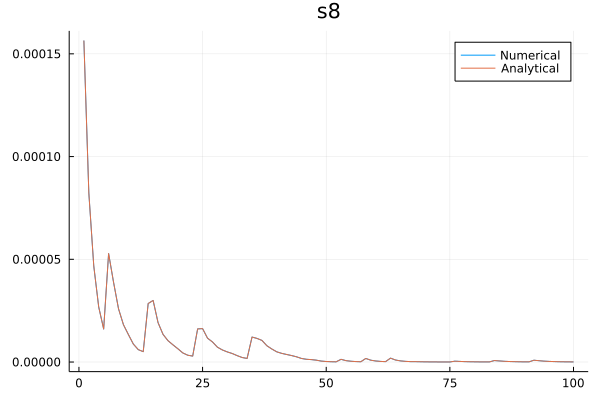

In [64]:
plot(numd_cls3(0.77)[1:100], label = "Numerical", title= "s8")
plot!(ForwardDiff.derivative(diff_cls3, 0.77)[1:100], label = "Analytical")

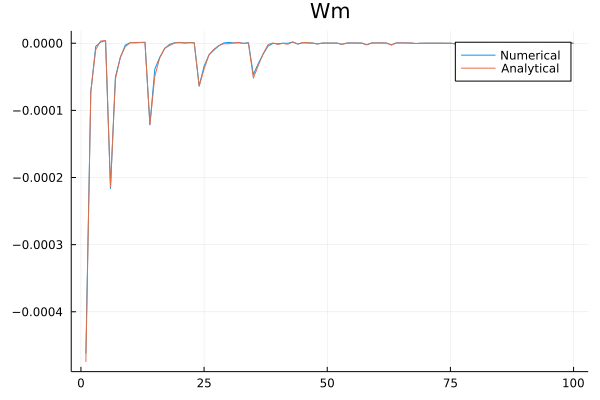

In [65]:
plot(numd_cls2(0.3)[1:100], label = "Numerical", title= "Wm")
plot!(ForwardDiff.derivative(diff_cls2, 0.3)[1:100], label = "Analytical")

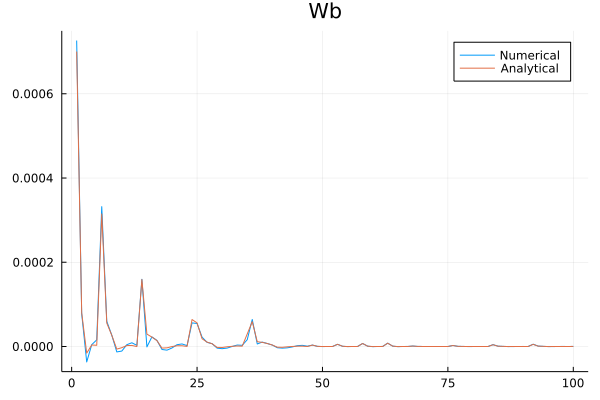

In [66]:
plot(numd_cls(0.035)[1:100], label = "Numerical", title= "Wb")
plot!(ForwardDiff.derivative(diff_cls, 0.035)[1:100], label = "Analytical")

In [70]:
max(comp_Wm[:])

LoadError: MethodError: no method matching max(::Vector{Float64})
[0mClosest candidates are:
[0m  max(::Any, [91m::Union{InitialValues.NonspecificInitialValue, InitialValues.SpecificInitialValue{typeof(max)}}[39m) at ~/.julia/packages/InitialValues/OWP8V/src/InitialValues.jl:161
[0m  max(::Any, [91m::Missing[39m) at /opt/julia-1.7.0/share/julia/base/missing.jl:137
[0m  max(::Any, [91m::Any[39m) at /opt/julia-1.7.0/share/julia/base/operators.jl:492
[0m  ...

In [67]:
comp_Wm = abs.((numd_cls2(0.3)[1:100] ./ ForwardDiff.derivative(diff_cls2, 0.3)[1:100]) .- 1)
comp_Wb = abs.((numd_cls(0.035)[1:100] ./ ForwardDiff.derivative(diff_cls, 0.035)[1:100]) .- 1)
comp_s8 = abs.((numd_cls3(0.77)[1:100] ./ ForwardDiff.derivative(diff_cls3, 0.77)[1:100]) .- 1)
println(mean(comp_Wm))
println(mean(comp_Wb))
println(mean(comp_s8))

0.2871971157951852
2.6867304805576104
6.493506601090048e-5


1.8309691684014588e-8


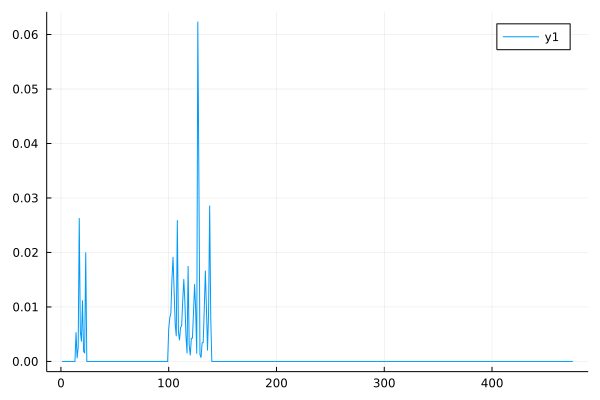

In [27]:
nume = numd_cls_nuisance(-0.01)
anal = ForwardDiff.derivative(diff_cls_nuisance, -0.01)
n = length(nume)
comp = zeros(Float64, n)

for i in 1:n 
    if (nume[i] != 0)
        comp[i] = @.(abs(anal[i]/nume[i] - 1))
    end
end

diff = []
for i in 1:n 
    if (nume[i] != 0)
        push!(diff, @.(abs(nume[i]-anal[i])))
    end
end
println(mean(diff))

plot(comp)

In [62]:
cls_jaime1 = make_cls(carlos_params1);

0.2535825 0.04426868 0.849544 0.8963611 0.8536883


In [29]:
open("jaime_cls.txt", "w") do io
       writedlm(io, cls_jaime1)
end

In [30]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];
compa2 = @. abs(cls_carlos2["cls"]-cls_jaime1)/cls_carlos2["cls"];

println("Mean discrepancy default   ", mean(compa1))
println("Mean discrepancy no itp    ", mean(compa2))

Mean discrepancy default   0.02634345582542703
Mean discrepancy no itp    0.024637756476413065


In [31]:
chi2_carlos = cls_carlos["chi2_nolp"]
chi2_carlos2 = cls_carlos2["chi2_nolp"]
println(chi2_carlos)
println(chi2_carlos2)

495.62231927779936
495.00947244084654


In [32]:
chi2_jaime1 = dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
println(chi2_jaime1)

507.20203294075816


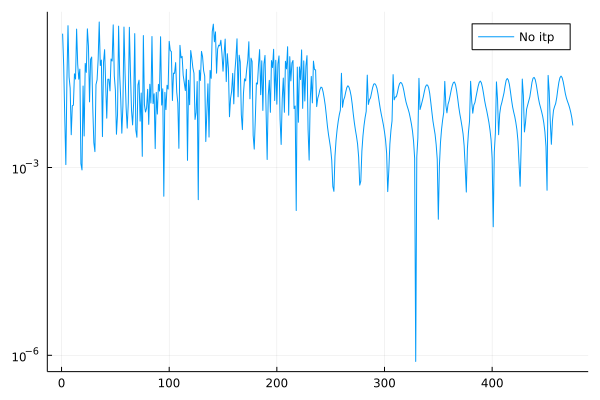

In [33]:
plot(compa2, label="No itp ", yaxis=:log)

In [34]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.6)
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    s8 = 0.81 #~ Uniform(0.6, 1.0)
    ns = 0.96 #~ Uniform(0.87, 1.07)
    
    b0 = 2.0
    dz_g0 ~ TruncatedNormal(0.008, 0.007, -2.0, 2.0)
    dz_g1 ~ TruncatedNormal(-0.005, 0.007, -2.0, 2.0)
    dz_g2 ~ TruncatedNormal(0.006, 0.006, -2.0, 2.0)
    dz_g3 ~ TruncatedNormal(0.0, 0.010, -2.0, 2.0)
    dz_g4 ~ TruncatedNormal(0.0, 0.010, -2.0, 2.0)

    nuisances = Dict(#"b0" => b0,
                     "dz_g0" => dz_g0,
                     "dz_g1" => dz_g1,
                     "dz_g2" => dz_g2,
                     "dz_g3" => dz_g3,
                     "dz_g4" => dz_g4)
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, s8, s8,
                                     tk_mode="emulator",
                                     Pk_mode="Halofit")
    theory = Theory(cosmology, Cls_meta, files;
                    Nuisances=nuisances).cls
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [19]:
iterations = 300
nadapts = 100;

In [20]:
chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:13


In [63]:
chain3 = sample(model(data_vector), NUTS(5, 0.1), iterations,
                progress=true; save_state=true);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, 

Sampling:   6%|██▍                                      |  ETA: 0:05:09┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   6%|██▌                                      |  ETA: 0:05:10┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   6%|██▋                                      |  ETA: 0:05:12┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   7%|██▊                                      |  ETA: 0:05:14┌ Warning: The current proposal will be rejected due to 

LoadError: InterruptException: